<a href="https://colab.research.google.com/github/parment1/Project-M1-M2/blob/main/Module_1_%26_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import pandas as pd
import os
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import statsmodels.api as sm
from functools import reduce
from pandas.tseries.offsets import MonthEnd  
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.stats.diagnostic as dg
from scipy.stats import anderson
from scipy.stats import shapiro
from scipy.stats import normaltest
from sklearn.linear_model import LinearRegression
from numpy import log
 

pd.set_option('display.max_rows',300)


Part I : Data acquisition, formating and cleaning

PART I project: Data acquisition, formating and cleaning

Dataset 1: Download the time series available on NASDAQ website for the Nasdaq Composite index, max history 2011 https://www.nasdaq.com/market-activity/index/ndx/historical

Dataset 2:

-GDP: We use GGP in percent change from preceding Period, quarterly, Seasonally Adjusted Annual Rate: Source: https://fred.stlouisfed.org/tags/series?t=quarterly

-CPI (consumer price inflation): Consumer Price Index: Growth Rate Same Period Previous Year, Monthly, Not Seasonally Adjusted. Source: https://fred.stlouisfed.org/tags/series?t=quarterly

-US Interest rates: Interest rates (%)

-US Unemployment rate Unemployment Rate, Percentfed.org/series/UNRATE

Problem: Do we see a relationship between the stock market and macroeconomic variables


In [102]:
#Open each xls/csv
Nasdaq = pd.read_excel('/content/Nasdaq composite index.xlsx')
#CPI = Consumer price index
CPI = pd.read_excel('/content/CPI monthly.xls')
#Interest_rate = fed fund rate
Interest_rate = pd.read_excel('/content/Fed fund.xls')
GDP = pd.read_excel('/content/GDP.xls')
Unemployment = pd.read_excel('/content/Unemployment.xls')


Explore the strucutre of the different datasets. They all have different shape with monthly data for Unemployment CPI and interest rate, daily for Nasdaq and quarterly for GDP.

We add the monthly percentage change of the Nasdaq



In [103]:
#check size of each dataset
print([Nasdaq.shape,CPI.shape,Interest_rate.shape,GDP.shape,Unemployment.shape])

[(2557, 6), (464, 2), (806, 2), (297, 2), (884, 2)]


In [104]:
#Align the column name for all data set
Nasdaq = Nasdaq.rename(columns={'Date': 'observation_date'})

#Select columns Date & Close/Last date from Nasdaq dataset
Nasdaq = Nasdaq[['observation_date','Close/Last']]
Nasdaq = Nasdaq.iloc[::-1].reset_index(drop=True)

#Get only monthly value for nadsqa (we can use either last day or first day of the month, need to be a trading day)
dates_month = pd.bdate_range(Nasdaq['observation_date'].min(), Nasdaq['observation_date'].max(), freq='1MS')

#Apply bdate range to the Nasdaq DF using isin
Nasdaq_mth = Nasdaq[Nasdaq['observation_date'].isin(dates_month)]
Nasdaq_mth.reset_index(inplace=True,drop=True)

#Calculate monthly return for the Nasdaq timeserie
Nasdaq_mth['Nasdaq composite index return'] =  Nasdaq_mth['Close/Last'].pct_change()*100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


# Nouvelle section

Each dataset has a column "observation_date", with a different length. The maximum time length publicly available for download is 10 years, we do the following steps

1. we adjust the other data frame to this timeframe for each DF, we set up the end date at end 2019
2. Check the new shape of each DF
3. Merge the different DF into one
4. Simplify the name of the columns

In [105]:
#Select observation period, adjust starting/ending value for different periods

starting_date = '2012-01-01'
ending_date = '2019-12-01'

#Function to select obeservation period, df = dataframe

def select_date(df):
  x = df[(df['observation_date'] >= starting_date) & (df['observation_date'] <= ending_date)]
  x.reset_index(inplace=True,drop=True)
  return x

#Apply to the different dataframe using pipe and create new DF with selected time period
Nasdaq_sample, Interest_rate_sample, CPI_sample, GDP_sample,Unemployment_sample = (df.pipe(select_date)for df in [Nasdaq_mth, Interest_rate,CPI, GDP,Unemployment])


In [106]:
#Check size of dataset after transformation
print([Nasdaq_sample.shape,CPI_sample.shape,Interest_rate_sample.shape,GDP_sample.shape,Unemployment_sample.shape])

[(64, 3), (96, 2), (96, 2), (32, 2), (96, 2)]


In [107]:
data_frames = [Nasdaq_sample,CPI_sample,Interest_rate_sample,Unemployment_sample,GDP_sample]

#Merge all DF into one based on "observation date" using the function melt, keep N/A if any

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['observation_date'],
                                            how='left'), data_frames)

#drop the column Close/Last and set "observation date" as index
df_merged_ = df_merged.drop('Close/Last', axis = 1)
df_merged_clean = df_merged_.set_index('observation_date')

#fillna 
#df_merged_clean = df_merged_clean.fillna(method='bfill')
#method='bfill'
#See column name
columns = df_merged_clean.columns
columns

Index(['Nasdaq composite index return', 'CPI (%)', 'Interest rate (%)',
       'Unemployment Rate (%)', 'Gross Domestic Product (%)'],
      dtype='object')

In [108]:
#test:

df_test = df_merged_clean.interpolate(method='linear', limit_direction ='forward')
# to interpolate the missing values

Text(0.5, 1.0, 'Gross Domestic Product')

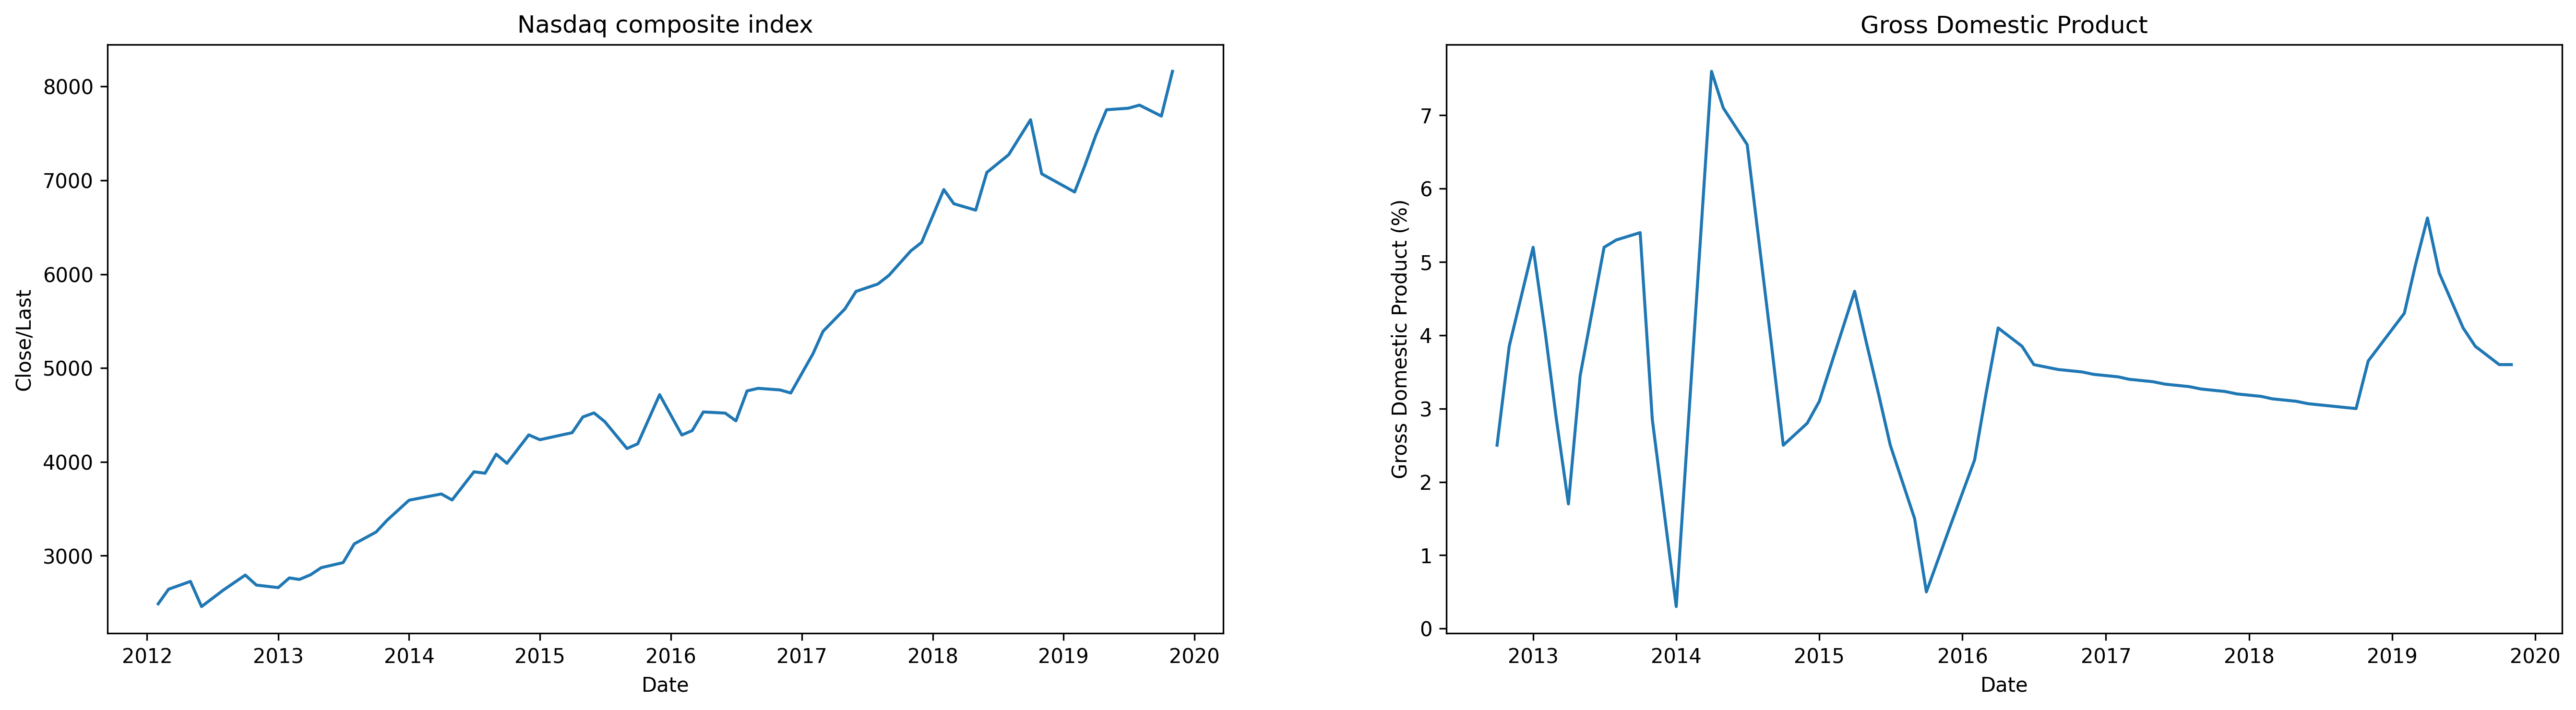

In [109]:
# Line plots
fig1 = plt.figure(figsize=(22, 10),dpi=300)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 1      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
fig1.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig1.add_subplot(221)
sns.lineplot(
    data=df_merged, 
#     kind="line",
    x='observation_date', 
    y="Close/Last")
plt.xlabel('Date')
plt.title('Nasdaq composite index')

ax2 = fig1.add_subplot(222)
sns.lineplot(
    data=df_test, 
#     kind="line",
    x='observation_date', 
    y="Gross Domestic Product (%)")
plt.xlabel('Date')
plt.title('Gross Domestic Product')

 A useful analyis of TS is to break the TS into systematic and unsystematic components:
        -Systematic: Components of the TS that have consistency or recurrence and can be described and model We have three systematic components:
             -Level: The average value in the series
             -Trend: The increasing or decreasing value in the series
             -Seasonality: The repeating short-term cycle in the series
        -Non-systematic: components of the time series that cannot be directly modeled
            -Noise: The random variation in the series

        A serie is the combination of the 4 elements. They can be additive our multiplicative.
        Additive model: y(t) = Level + trend + seasonality + noise (linear model)
        Mutliplicative model: y(t) = Level * trend * seasonality * noise (non linear model, changes increase or decrease over time, curved line)

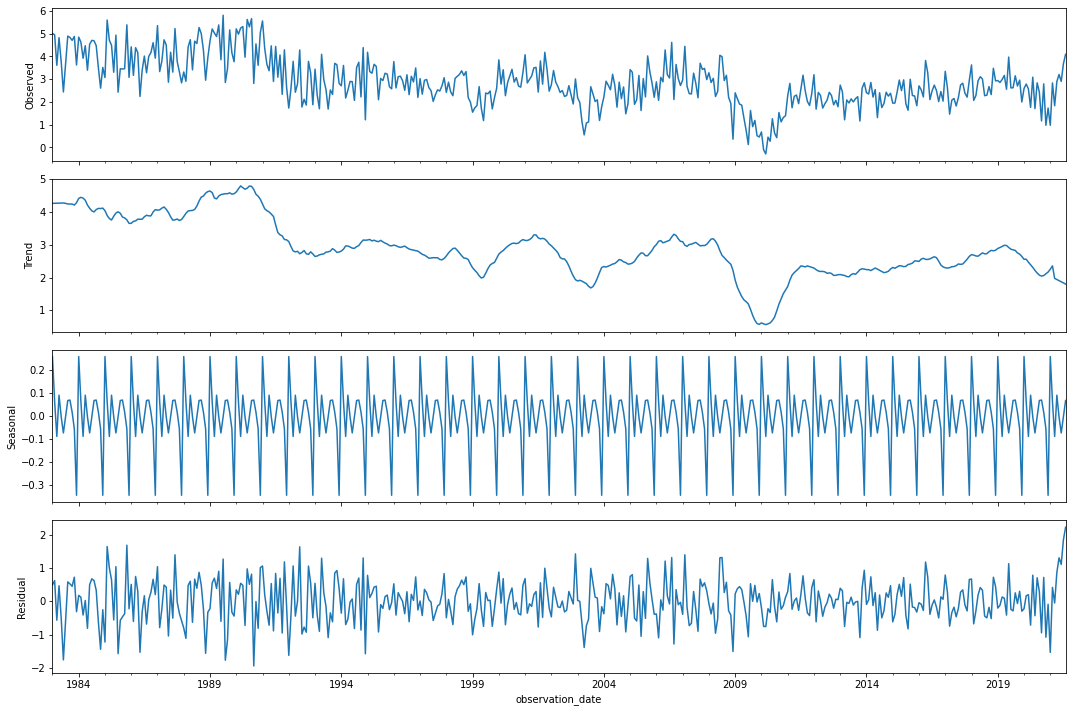

In [110]:
#Additive and multiplicative decomposition, reload the data without header and index_col, easiest method I foud to use  Seasonal decomposition:
Nasdaq_ = pd.read_excel('/content/Nasdaq composite index.xlsx', header=0,index_col=0)
CPI_ = pd.read_excel('/content/CPI monthly.xls', header=0,index_col=0)
Interest_rate_ = pd.read_excel('/content/Fed fund.xls',header=0,index_col=0)
GDP_ = pd.read_excel('/content/GDP.xls',header=0,index_col=0)
Unemployment_ = pd.read_excel('/content/Unemployment.xls',header=0,index_col=0)

def seasonal_dec(df,model,extrapolate_Trend):
        result = seasonal_decompose(df, model = model,extrapolate_trend=extrapolate_Trend)
        plt.rcParams['figure.figsize'] = [15, 10]
        result.plot()
        plt.show()

CPI_decompose = seasonal_dec(CPI_,'Additive Decompose','freq')

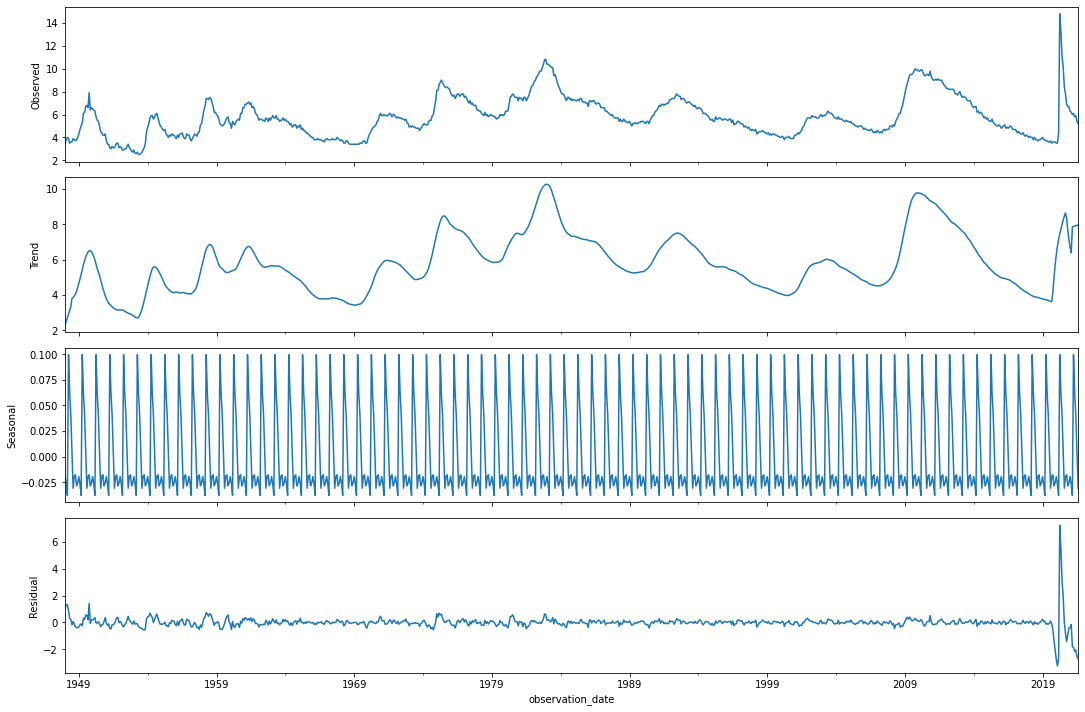

In [111]:
Unemployment_decompose = seasonal_dec(Unemployment_,'Additive Decompose','freq')

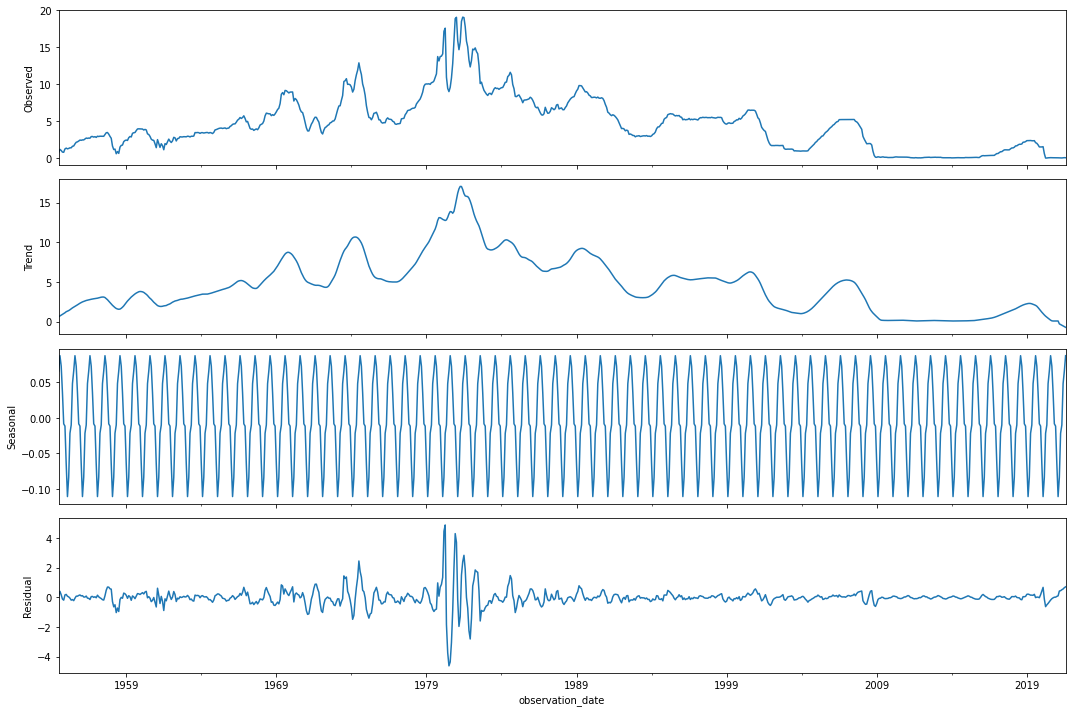

In [112]:
IR_decompose = seasonal_dec(Interest_rate_,'Additive Decompose','freq')

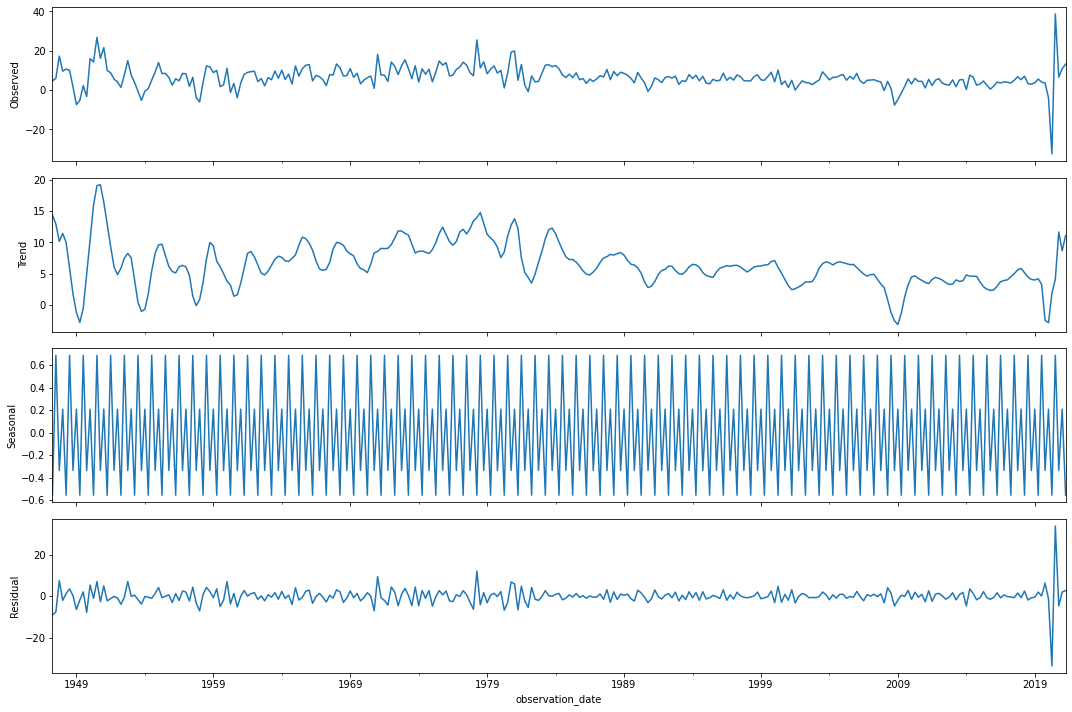

In [113]:
GDP_decompose = seasonal_dec(GDP_,'Additive Decompose','freq')

In [114]:
df_merged_clean.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64 entries, 2012-02-01 to 2019-11-01
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Nasdaq composite index return  64 non-null     float64
 1   CPI (%)                        64 non-null     float64
 2   Interest rate (%)              64 non-null     float64
 3   Unemployment Rate (%)          64 non-null     float64
 4   Gross Domestic Product (%)     19 non-null     float64
dtypes: float64(5)
memory usage: 3.0 KB


In [115]:
df_merged_clean.isna().sum()


Nasdaq composite index return     0
CPI (%)                           0
Interest rate (%)                 0
Unemployment Rate (%)             0
Gross Domestic Product (%)       45
dtype: int64

In [116]:
df_merged_clean.head(20)

,Nasdaq composite index return,CPI (%),Interest rate (%),Unemployment Rate (%),Gross Domestic Product (%)
observation_date,,,,,
2012-02-01,7.750736,1.684552,0.10,8.3,NaN
2012-03-01,6.243921,2.420296,0.13,8.2,NaN
2012-05-01,3.154104,1.732072,0.16,8.2,NaN
2012-06-01,-9.831238,1.922063,0.16,8.2,NaN
2012-08-01,7.170077,2.423866,0.13,8.1,NaN
2012-10-01,6.039550,1.875048,0.16,7.8,2.5
2012-11-01,-3.820662,2.072155,0.16,7.7,NaN
2013-01-01,-0.989388,2.741808,0.14,8.0,5.2
2013-02-01,3.871955,2.451542,0.15,7.7,NaN



Part II: Descriptive analysis

-Check how dataset looks like
-Plot the different dataset
-Correlation matrix
-Cointegration matrix
-Test

Check how the data are distrbitued with  a kernel density estimate to smooth the histogram



In [117]:
df_columns = df_merged_clean.columns


In [118]:
df_merged_clean = df_merged_clean[['Nasdaq composite index return','CPI (%)','Interest rate (%)', 'Unemployment Rate (%)','Gross Domestic Product (%)']]

In [119]:
df_columns_= df_merged_clean.columns
df_merged_clean = df_merged_clean.fillna(method="ffill")
df_merged_clean.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64 entries, 2012-02-01 to 2019-11-01
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Nasdaq composite index return  64 non-null     float64
 1   CPI (%)                        64 non-null     float64
 2   Interest rate (%)              64 non-null     float64
 3   Unemployment Rate (%)          64 non-null     float64
 4   Gross Domestic Product (%)     59 non-null     float64
dtypes: float64(5)
memory usage: 3.0 KB


Text(0.5, 1.0, 'Unemployment rate (%)')

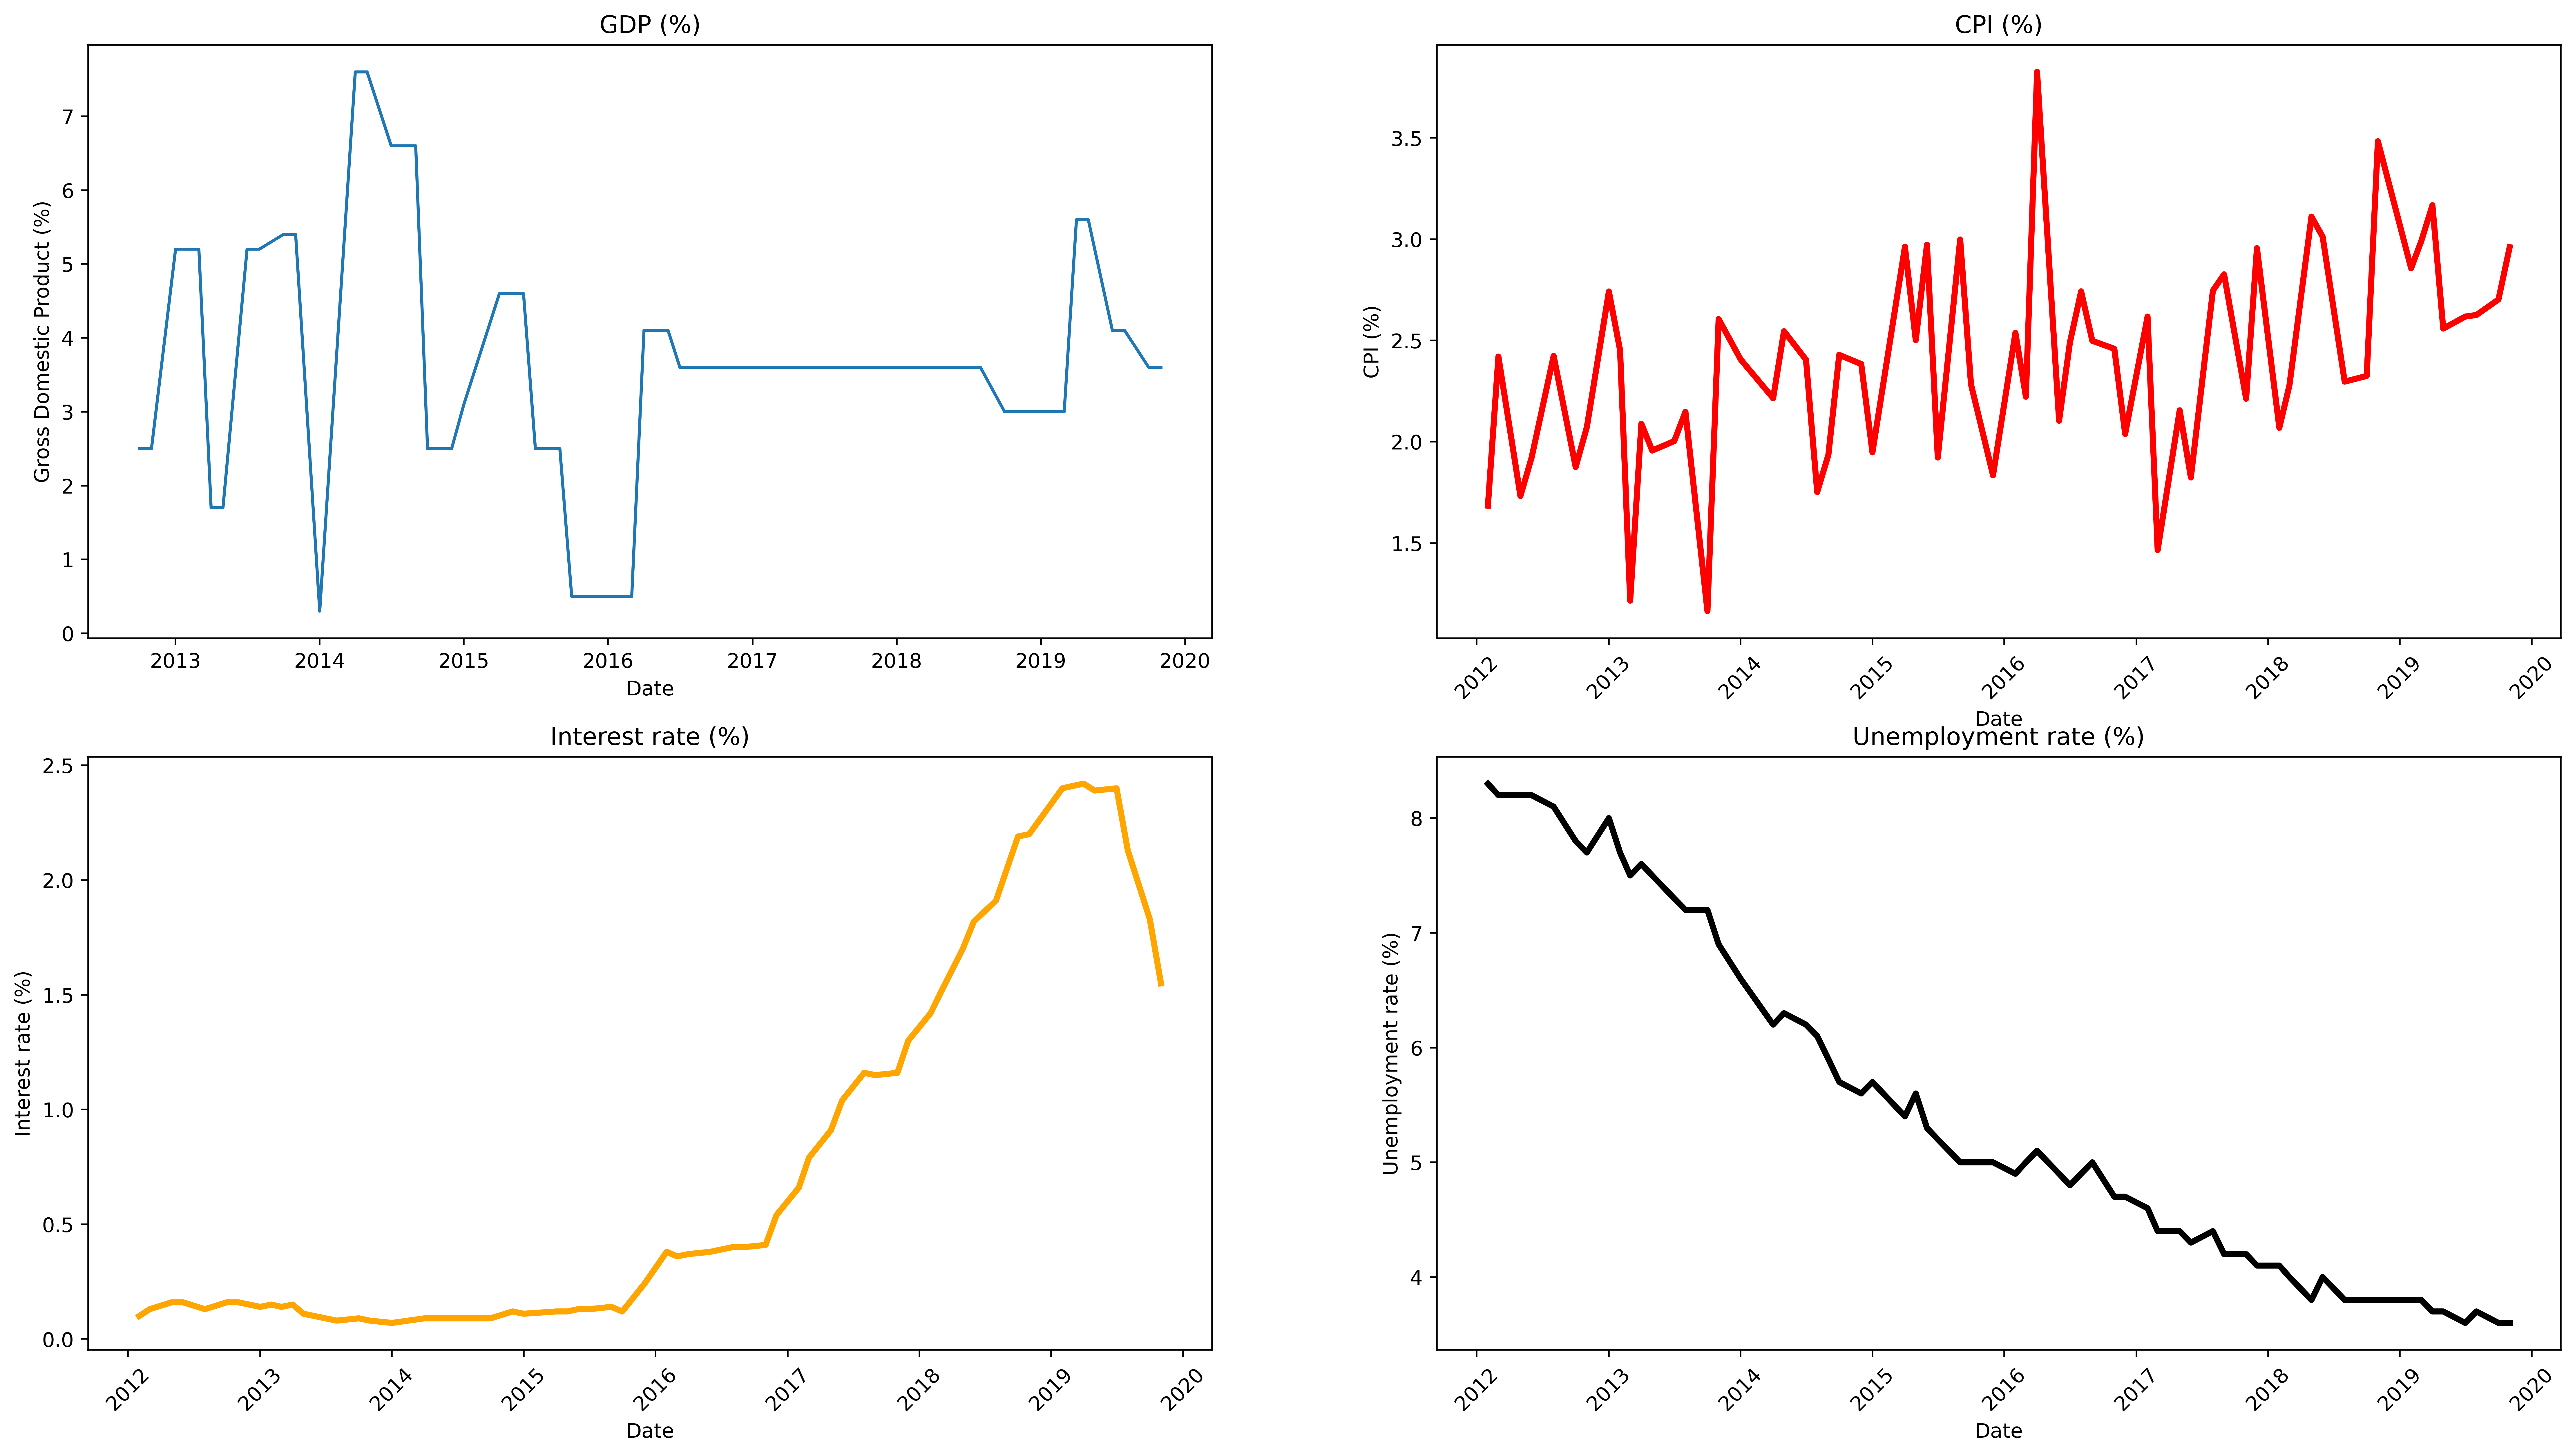

In [120]:
# Line plots
fig1 = plt.figure(figsize=(22, 10),dpi=500)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 1      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
fig1.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig1.add_subplot(221)
sns.lineplot(
    data=df_merged_clean, 
#     kind="line",
    x=df_merged_clean.index, 
    y="Gross Domestic Product (%)")
plt.xlabel('Date')
plt.title('GDP (%)')

ax2 = fig1.add_subplot(222)
sns.lineplot(
    data=df_merged_clean, 
    x=df_merged_clean.index, 
    y="CPI (%)",
    ax = ax2,
    linewidth = 3,
    color = 'red')
plt.xticks(rotation=45) 
plt.ylabel('CPI (%)')
plt.xlabel('Date')
plt.title('CPI (%)')

ax3 = fig1.add_subplot(223)
sns.lineplot(
    data=df_merged_clean, 
    x=df_merged_clean.index, 
    y="Interest rate (%)",
    ax = ax3,
    linewidth = 3,
    color = 'orange')
plt.xticks(rotation=45) 
plt.ylabel('Interest rate (%)')
plt.xlabel('Date')
plt.title('Interest rate (%)')

ax4 = fig1.add_subplot(224)
sns.lineplot(
    data=df_merged_clean, 
    x=df_merged_clean.index, 
    y="Unemployment Rate (%)",
    ax = ax4,
    linewidth = 3,
    color = 'black')
plt.xticks(rotation=45) 
plt.ylabel('Unemployment rate (%)')
plt.xlabel('Date')
plt.title('Unemployment rate (%)')



In [121]:
round(df_merged_clean.describe(),2)

,Nasdaq composite index return,CPI (%),Interest rate (%),Unemployment Rate (%),Gross Domestic Product (%)
count,64.00,64.00,64.00,64.00,59.00
mean,2.09,2.39,0.72,5.46,3.75
std,4.36,0.50,0.80,1.51,1.63
min,-9.83,1.16,0.07,3.60,0.30
25%,-0.61,2.06,0.12,4.18,3.00
50%,1.86,2.41,0.30,5.00,3.60
75%,4.75,2.71,1.19,6.67,4.60
max,12.48,3.83,2.42,8.30,7.60


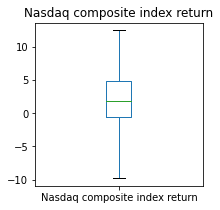

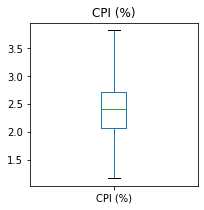

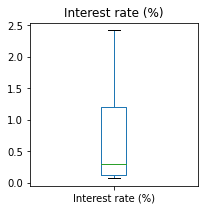

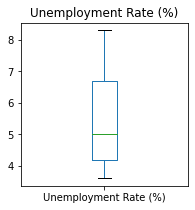

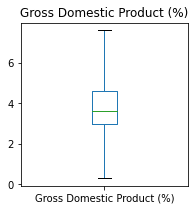

In [122]:
for i in df_columns:
  df_merged_clean[i].plot(kind='box',figsize=(3,3), title=i,whis=2)
  plt.show()

In [123]:
df_merged_clean = df_merged_clean.fillna(method='bfill')

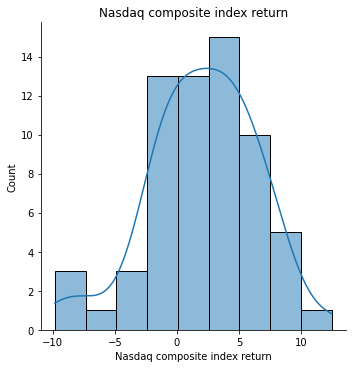

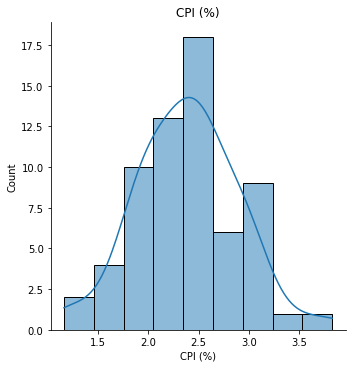

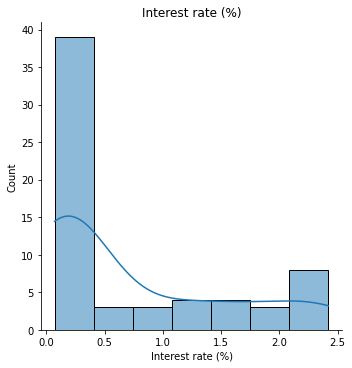

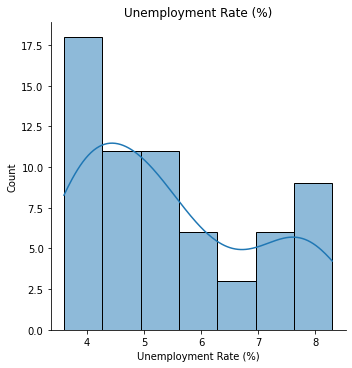

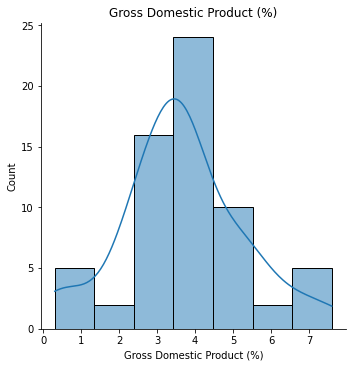

In [124]:
#Visualisation data distribution
for i in df_columns:
  sns.displot(df_merged_clean, x=i,kde=True)
  plt.title(i)

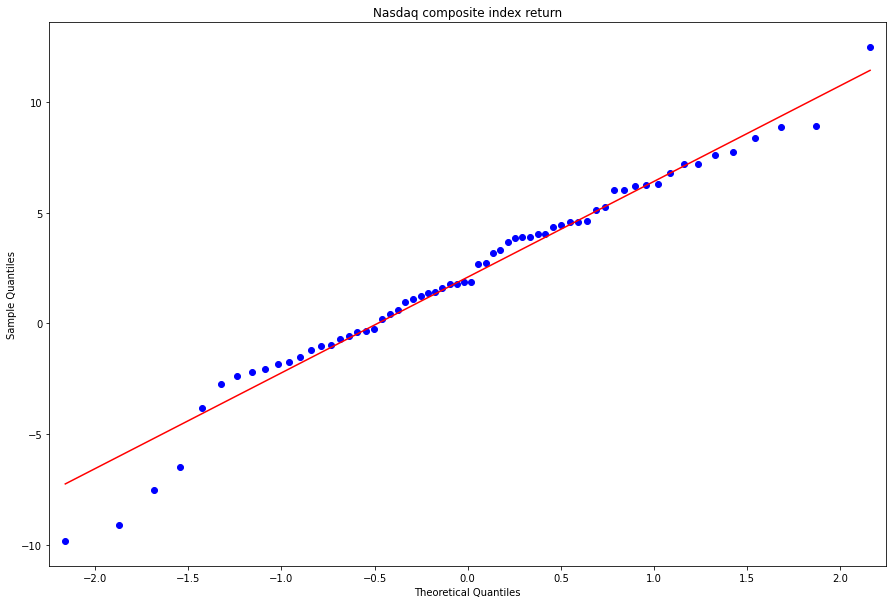

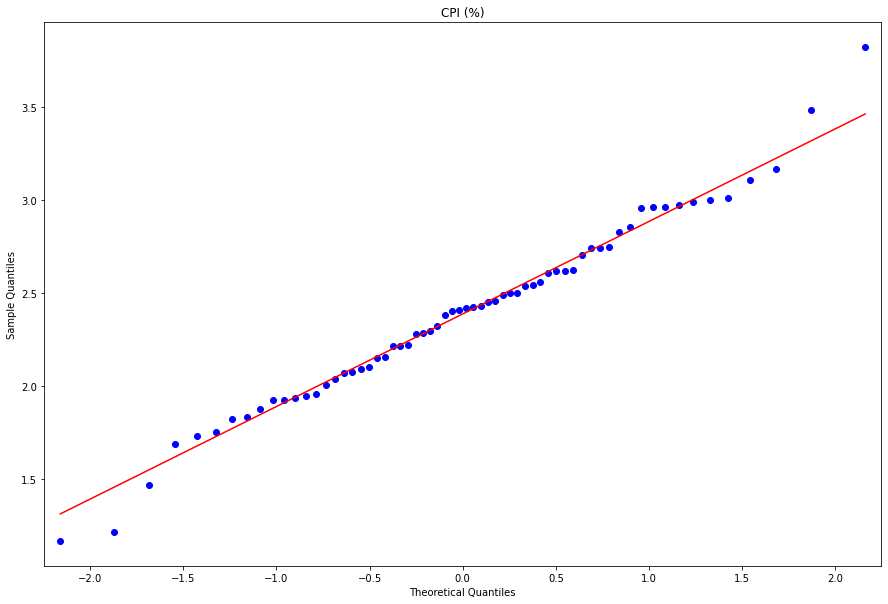

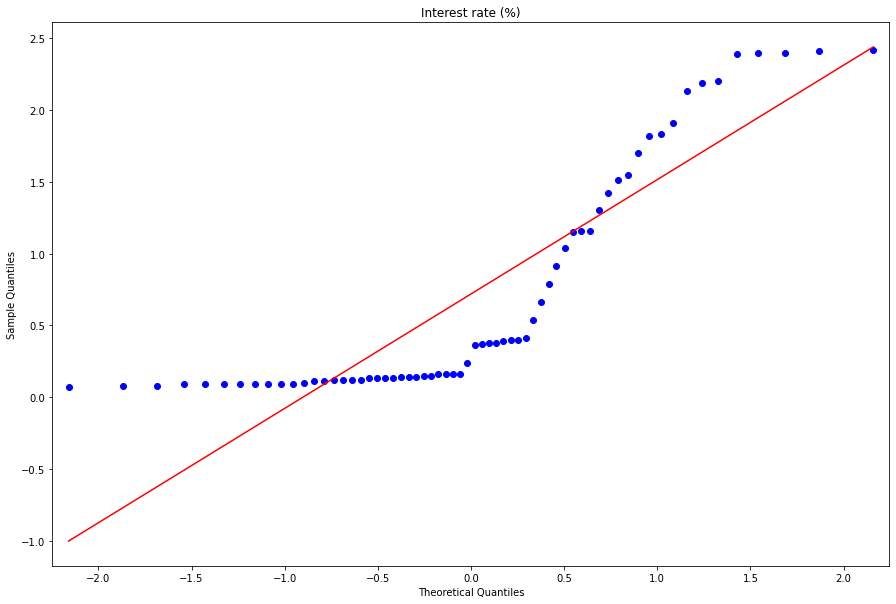

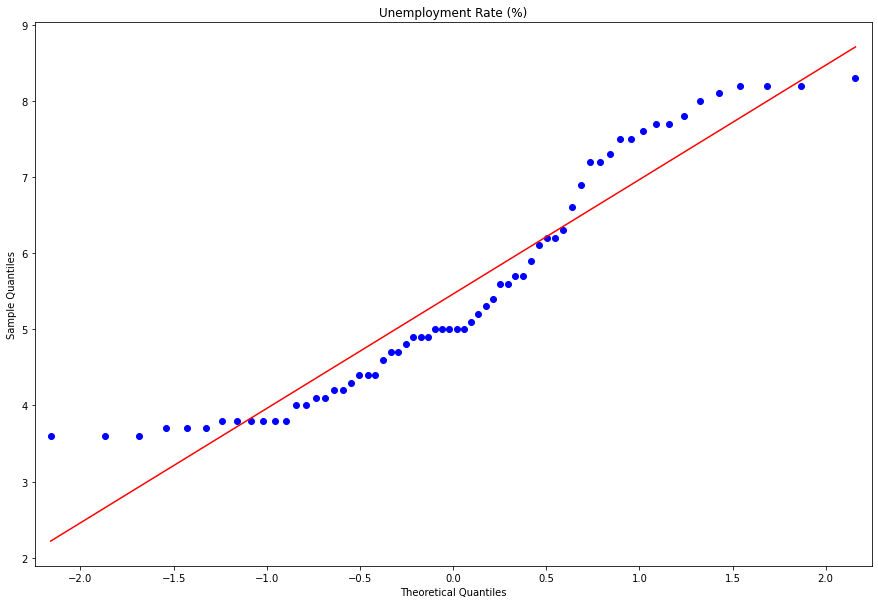

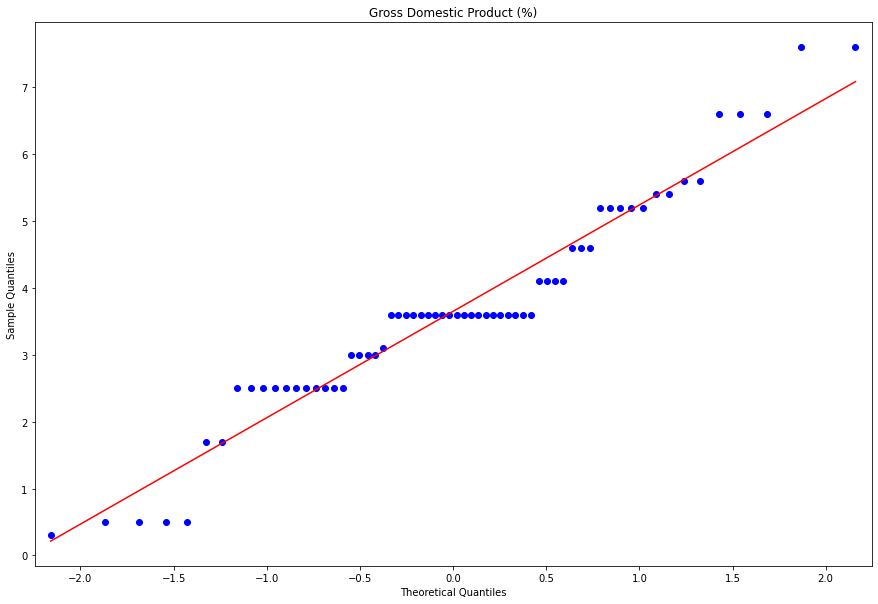

In [125]:
#checking the distribution of a data sample iwiths the quantile-quantile plot, Q-Q plot
for i in df_columns:
  qqplot(df_merged_clean[i], line='s')
  plt.title(i)
  plt.show()


In [126]:
# Anderson Test for Gaussian distribution
for i in df_columns: 
  result = anderson(df_merged_clean[i])
  print(' ')
  print(i + ' Statistic: %.3f' % result.statistic)
  p = 0
  for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
      print(' %.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
      print(' %.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

 
Nasdaq composite index return Statistic: 0.382
 15.000: 0.545, data looks normal (fail to reject H0)
 10.000: 0.621, data looks normal (fail to reject H0)
 5.000: 0.745, data looks normal (fail to reject H0)
 2.500: 0.869, data looks normal (fail to reject H0)
 1.000: 1.034, data looks normal (fail to reject H0)
 
CPI (%) Statistic: 0.202
 15.000: 0.545, data looks normal (fail to reject H0)
 10.000: 0.621, data looks normal (fail to reject H0)
 5.000: 0.745, data looks normal (fail to reject H0)
 2.500: 0.869, data looks normal (fail to reject H0)
 1.000: 1.034, data looks normal (fail to reject H0)
 
Interest rate (%) Statistic: 6.273
 15.000: 0.545, data does not look normal (reject H0)
 10.000: 0.621, data does not look normal (reject H0)
 5.000: 0.745, data does not look normal (reject H0)
 2.500: 0.869, data does not look normal (reject H0)
 1.000: 1.034, data does not look normal (reject H0)
 
Unemployment Rate (%) Statistic: 2.088
 15.000: 0.545, data does not look normal (re

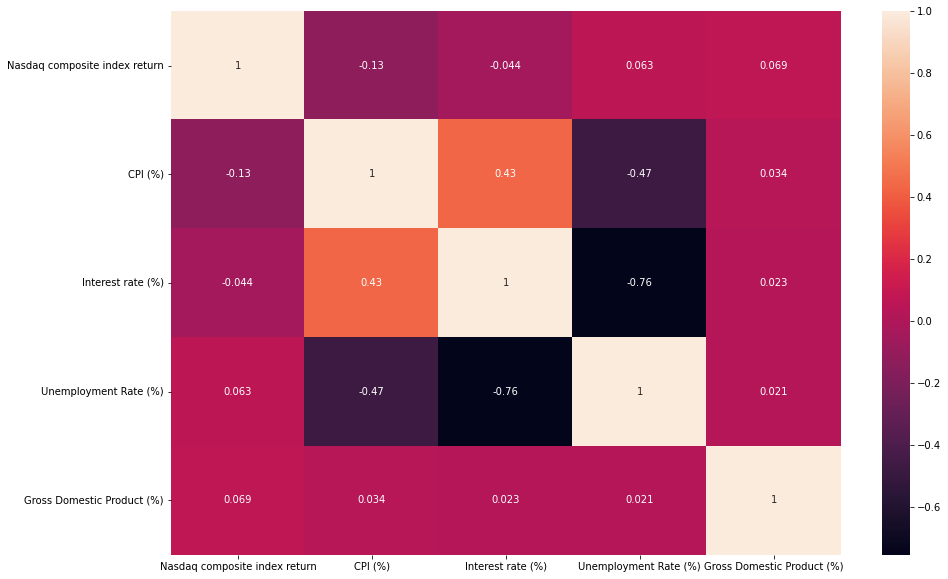

In [127]:
#Create correlation matrix 
corrMatrix = df_merged_clean.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

When dealing with time series data, it is important to examine the existence of unit root in the  data series.  A non-stationary process generates the problem of  spurious regression between unrelated variables. We use the Augmented Dickey-Fuller (ADF) test. 


In [128]:
#Function for the ADF test
def ADF_test(DF,columns):
  #DF = dataframe
  #columns = columns of DF
  for i in columns:
    X = DF[i].values
    result = adfuller(X)
    print(i)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))

#function of the ADF test to smooth the data a bit more
def ADF_log_test(DF,columns):
  for i in columns:
    X = DF[i].values
    X = log(X)
    X = X[np.logical_not(np.isnan(X))]
    result = adfuller(X)
    print(i + ' ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))

ADF_test(df_merged_clean,df_columns)

Nasdaq composite index return
ADF Statistic: -8.203444
p-value: 0.000000
Critical Values:
	1%: -3.541
	5%: -2.909
	10%: -2.592
CPI (%)
ADF Statistic: -4.112291
p-value: 0.000924
Critical Values:
	1%: -3.541
	5%: -2.909
	10%: -2.592
Interest rate (%)
ADF Statistic: -4.147108
p-value: 0.000809
Critical Values:
	1%: -3.563
	5%: -2.919
	10%: -2.597
Unemployment Rate (%)
ADF Statistic: -2.084866
p-value: 0.250644
Critical Values:
	1%: -3.541
	5%: -2.909
	10%: -2.592
Gross Domestic Product (%)
ADF Statistic: -4.579524
p-value: 0.000141
Critical Values:
	1%: -3.539
	5%: -2.909
	10%: -2.592


In [129]:
#Once we executed the ADF test, we first difference the independent variables wehere the time series is non-stationary
columns = ['CPI (%)','Interest rate (%)','Unemployment Rate (%)','Gross Domestic Product (%)']
df_merged_clean_first_difference = df_merged_clean[columns].diff().dropna()
df_columns_first_difference = df_merged_clean_first_difference.columns

ADF_test(df_merged_clean_first_difference,df_columns_first_difference)

CPI (%)
ADF Statistic: -2.450337
p-value: 0.128030
Critical Values:
	1%: -3.566
	5%: -2.920
	10%: -2.598
Interest rate (%)
ADF Statistic: -0.878080
p-value: 0.795105
Critical Values:
	1%: -3.542
	5%: -2.910
	10%: -2.593
Unemployment Rate (%)
ADF Statistic: -9.981486
p-value: 0.000000
Critical Values:
	1%: -3.541
	5%: -2.909
	10%: -2.592
Gross Domestic Product (%)
ADF Statistic: -5.819756
p-value: 0.000000
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594


Text(0.5, 1.0, 'Unemployment rate (%)')

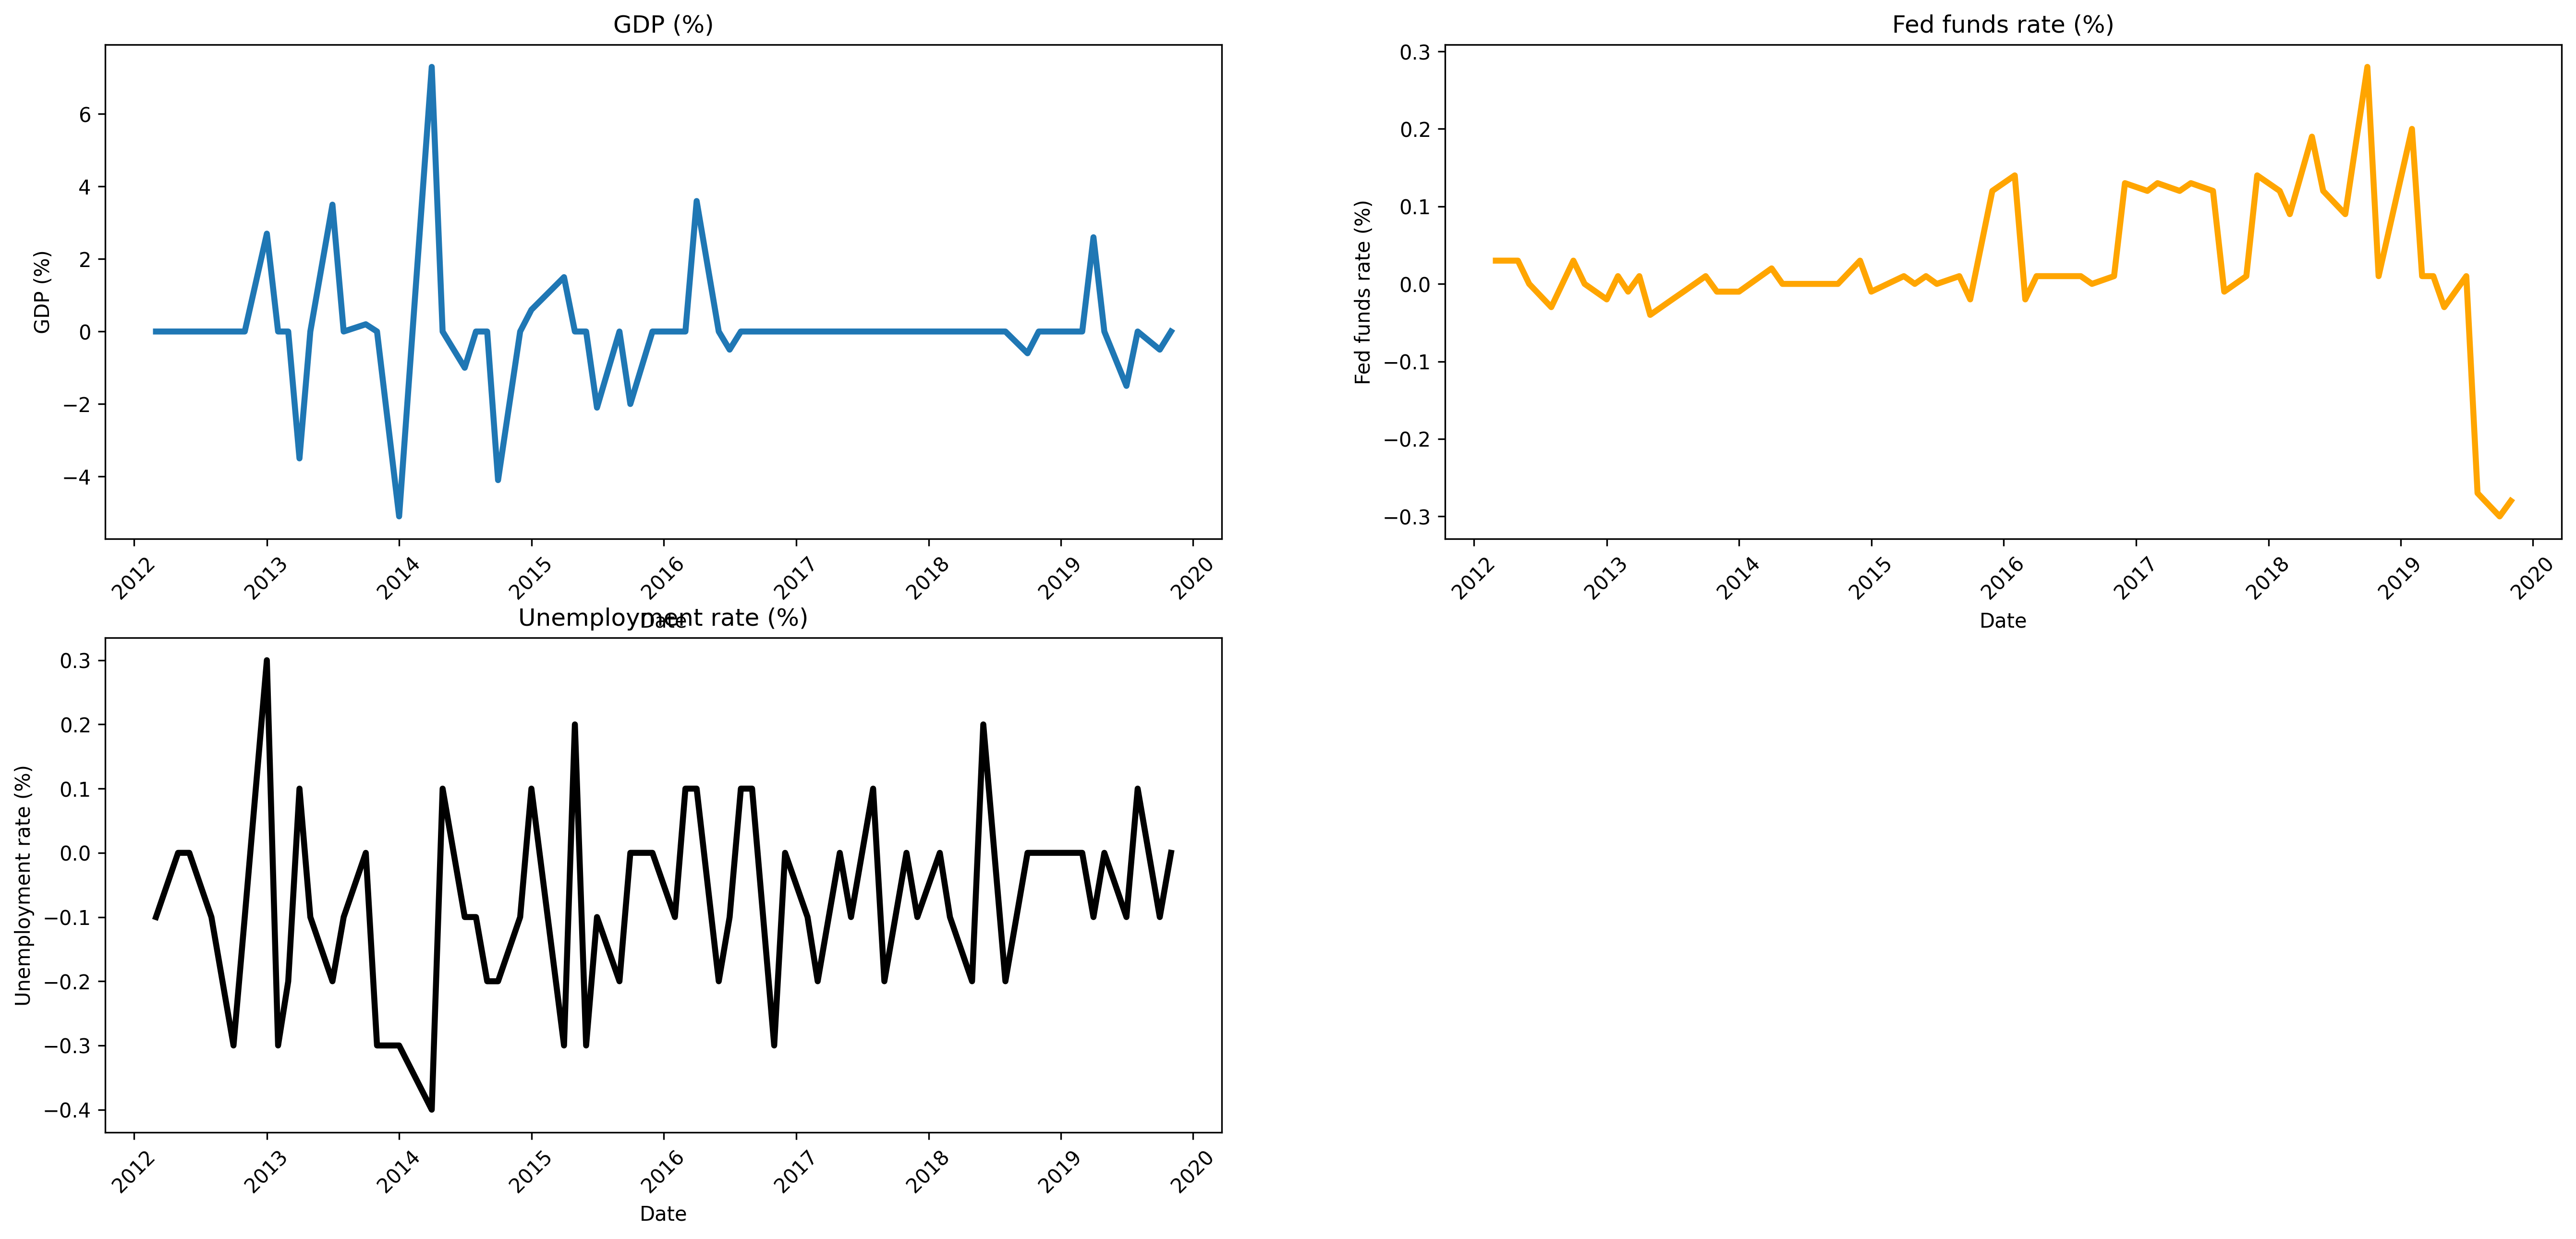

In [130]:
# Line plots
fig2 = plt.figure(figsize=(22, 10),dpi=300)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 1      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
fig1.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig2.add_subplot(221)
sns.lineplot(
    data=df_merged_clean_first_difference, 
#     kind="line",
    x=df_merged_clean_first_difference.index, 
    y="Gross Domestic Product (%)",
    ax = ax1,
    linewidth = 3)
plt.xticks(rotation=45) 
plt.ylabel('GDP (%)')
plt.xlabel('Date')
plt.title('GDP (%)')

ax2 = fig2.add_subplot(222)
sns.lineplot(
    data=df_merged_clean_first_difference, 
    x=df_merged_clean_first_difference.index, 
    y="Interest rate (%)",
    ax = ax2,
    linewidth = 3,
    color = 'orange')
plt.xticks(rotation=45) 
plt.ylabel('Interest rate (%)')
plt.xlabel('Date')
plt.title('Interest rate (%)')

ax3 = fig2.add_subplot(223)
sns.lineplot(
    data=df_merged_clean_first_difference, 
    x=df_merged_clean_first_difference.index, 
    y="Unemployment Rate (%)",
    ax = ax3,
    linewidth = 3,
    color = 'black')
plt.xticks(rotation=45) 
plt.ylabel('Unemployment rate (%)')
plt.xlabel('Date')
plt.title('Unemployment rate (%)')


In [131]:
#We re-do the same and look for the second difference for the independent variables still non-stationary even after first-difference
columns_second = ['Unemployment Rate (%)','Interest rate (%)']
df_merged_clean_second_difference = df_merged_clean_first_difference[columns_second].diff().dropna()
df_columns_second_difference = df_merged_clean_second_difference.columns
ADF_test(df_merged_clean_second_difference,df_columns_second_difference)

Unemployment Rate (%)
ADF Statistic: -5.779671
p-value: 0.000001
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
Interest rate (%)
ADF Statistic: -12.541506
p-value: 0.000000
Critical Values:
	1%: -3.542
	5%: -2.910
	10%: -2.593


Text(0.5, 1.0, 'Unemployment rate (%)')

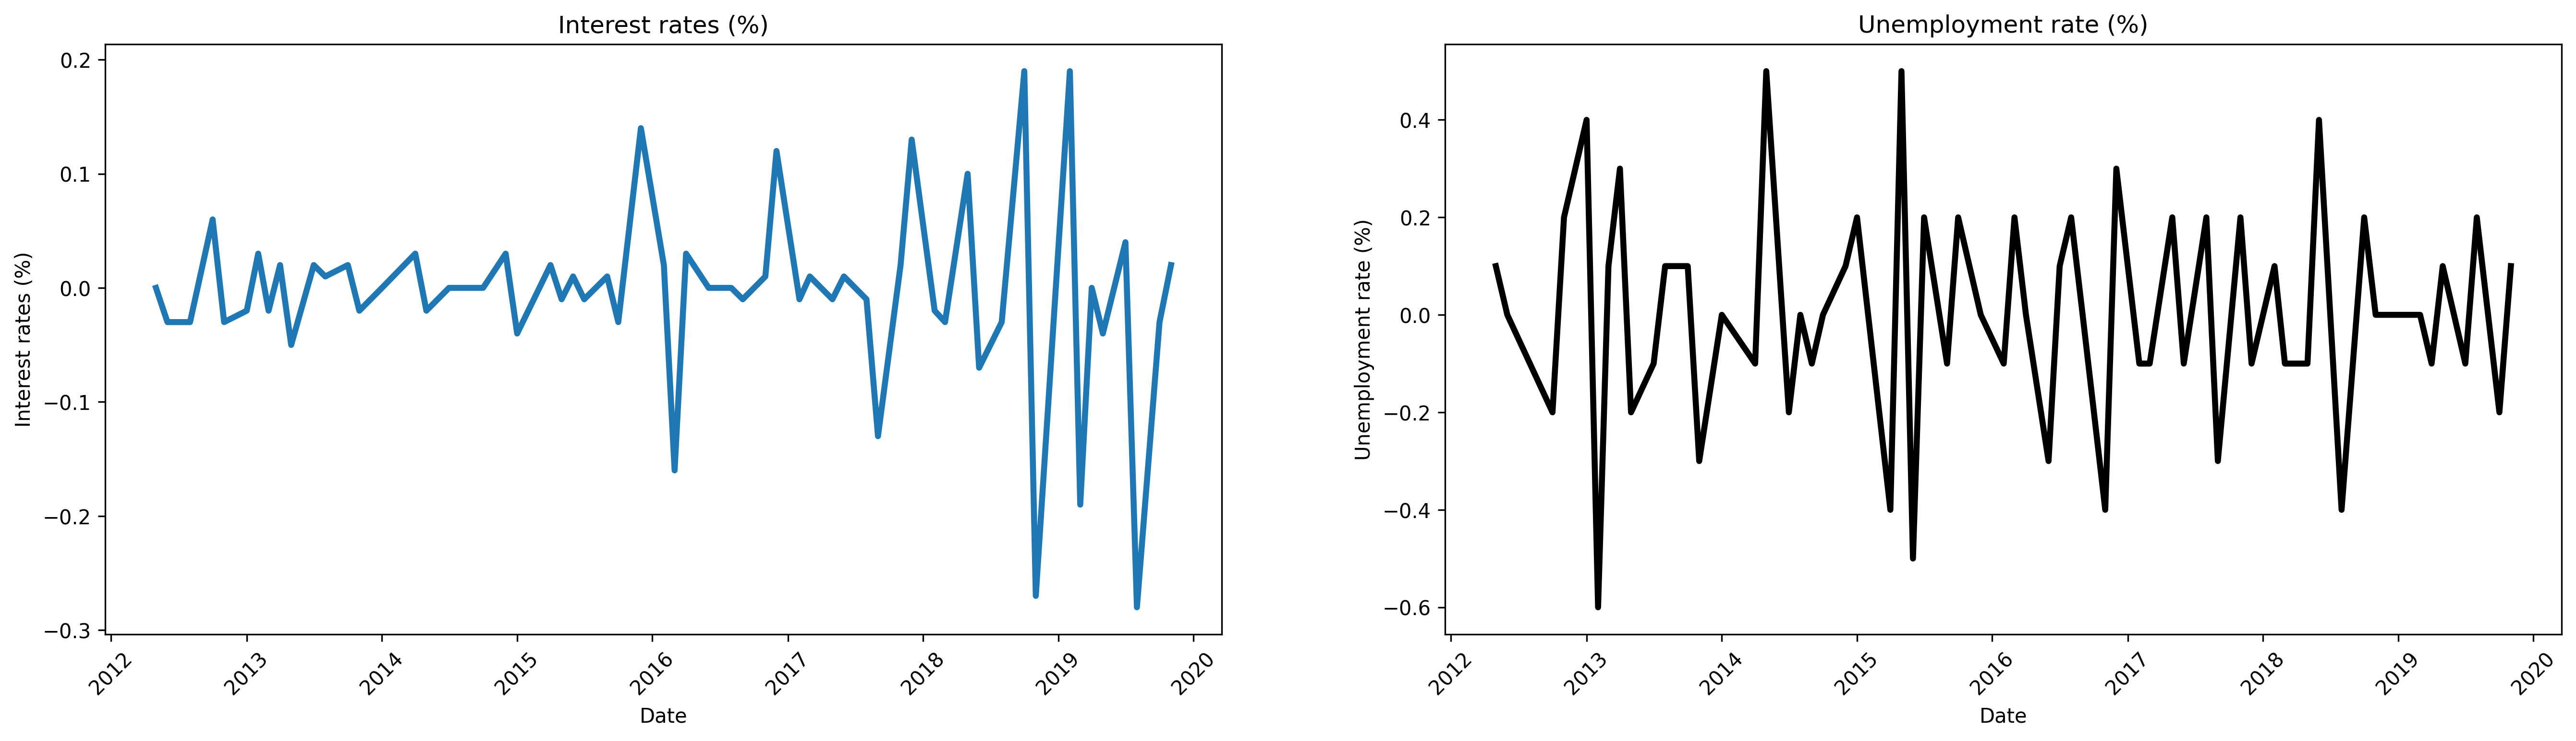

In [134]:
# Line plots
fig3 = plt.figure(figsize=(22, 10),dpi=300)
fig3.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig3.add_subplot(221)
sns.lineplot(
    data=df_merged_clean_second_difference, 
    x=df_merged_clean_second_difference.index, 
    y="Interest rate (%)",
    ax = ax1,
    linewidth = 3)
plt.xticks(rotation=45) 
plt.ylabel('Interest rates (%)')
plt.xlabel('Date')
plt.title('Interest rates (%)')

ax2 = fig3.add_subplot(222)
sns.lineplot(
    data=df_merged_clean_second_difference, 
    x=df_merged_clean_second_difference.index, 
    y="Unemployment Rate (%)",
    ax = ax2,
    linewidth = 3,
    color = 'black')
plt.xticks(rotation=45) 
plt.ylabel('Unemployment rate (%)')
plt.xlabel('Date')
plt.title('Unemployment rate (%)')

In [135]:
#We re-do the same and look for the second difference for the independent variables still non-stationary even after first-difference
columns_third = ['Interest rate (%)']
df_merged_clean_third_difference = df_merged_clean_second_difference[columns_third].diff().dropna()
df_columns_third_difference = df_merged_clean_third_difference.columns
ADF_test(df_merged_clean_third_difference,df_columns_third_difference)

Interest rate (%)
ADF Statistic: -4.413516
p-value: 0.000281
Critical Values:
	1%: -3.560
	5%: -2.918
	10%: -2.597


Text(0.5, 1.0, 'Interest rate (%)')

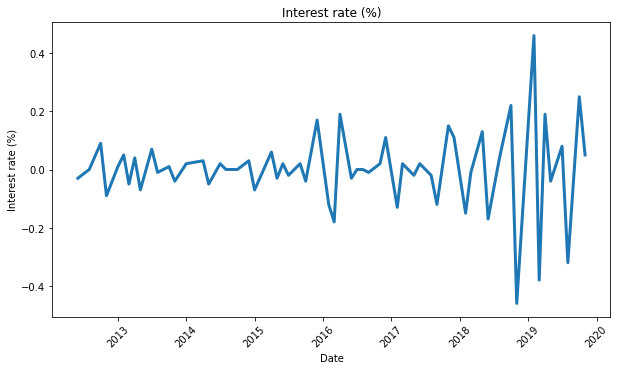

In [137]:
# Line plots
fig4 = plt.figure(figsize=(22, 10))
fig4.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig4.add_subplot(221)
sns.lineplot(
    data=df_merged_clean_third_difference, 
#     kind="line",
    x=df_merged_clean_third_difference.index, 
    y="Interest rate (%)",
    ax = ax1,
    linewidth = 3)
plt.xticks(rotation=45) 
plt.ylabel('Interest rate (%)')
plt.xlabel('Date')
plt.title('Interest rate (%)')

In [139]:
#We select the columns where we executed the first & second difference
selected_first = df_merged_clean[['Nasdaq composite index return']]
selected_second  = df_merged_clean_first_difference[['CPI (%)','Gross Domestic Product (%)']]
selected_third = df_merged_clean_second_difference[['Unemployment Rate (%)']]
data_frames_ = [df_merged_clean_third_difference,selected_first,selected_second,selected_third]

#Merge all DF into one based on "observation date" using the function melt, keep N/A if any

df_total = reduce(lambda  left,right: pd.merge(left,right,on=['observation_date'],
                                            how='left'), data_frames_)
columns_ = ['CPI (%)','Interest rate (%)','Unemployment Rate (%)','Gross Domestic Product (%)']
columns_2 = ['Interest rate (%)','Unemployment Rate (%)','Gross Domestic Product (%)']

In [140]:
for i in columns_2:
    df_total[i] = df_total[i].shift(1)

In [141]:
df_total = df_total.dropna()

In [142]:
#We execute the OLS analysis. After the difference modifications (firs/second differences) our OLS model is as followed:
#(Nasdaq Monthly Return)t = α1 + β1*(CPI)t + β2FD* (Effective fund rates)t + β3FD2 *(Unemployment)t + β4FD2 * (GDP)t
#FD = First difference
#FD2 = Second difference
x = df_total[columns_]
Y = df_total['Nasdaq composite index return']
x = sm.add_constant(x)
model = sm.OLS(Y, x)
results = model.fit()
print(results.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Nasdaq composite index return   R-squared:                       0.060
Model:                                       OLS   Adj. R-squared:                 -0.009
Method:                            Least Squares   F-statistic:                    0.8748
Date:                           Sun, 24 Oct 2021   Prob (F-statistic):              0.485
Time:                                   12:33:03   Log-Likelihood:                -167.77
No. Observations:                             60   AIC:                             345.5
Df Residuals:                                 55   BIC:                             356.0
Df Model:                                      4                                         
Covariance Type:                       nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----

In [143]:
maxlag=3
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):       
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

output = grangers_causation_matrix(df_total, variables = df_total.columns)
 

In [144]:
output

,Interest rate (%)_x,Nasdaq composite index return_x,CPI (%)_x,Gross Domestic Product (%)_x,Unemployment Rate (%)_x
Interest rate (%)_y,1.0000,0.1353,0.0229,0.4784,0.2640
Nasdaq composite index return_y,0.3280,1.0000,0.2880,0.0840,0.5088
CPI (%)_y,0.7598,0.0060,1.0000,0.1815,0.0011
Gross Domestic Product (%)_y,0.4689,0.7735,0.0082,1.0000,0.3079
Unemployment Rate (%)_y,0.5079,0.2358,0.1775,0.2888,1.0000


In [145]:
output['CPI (%)_x']['Nasdaq composite index return_y'] = 0.01244


In [146]:
output

,Interest rate (%)_x,Nasdaq composite index return_x,CPI (%)_x,Gross Domestic Product (%)_x,Unemployment Rate (%)_x
Interest rate (%)_y,1.0000,0.1353,0.02290,0.4784,0.2640
Nasdaq composite index return_y,0.3280,1.0000,0.01244,0.0840,0.5088
CPI (%)_y,0.7598,0.0060,1.00000,0.1815,0.0011
Gross Domestic Product (%)_y,0.4689,0.7735,0.00820,1.0000,0.3079
Unemployment Rate (%)_y,0.5079,0.2358,0.17750,0.2888,1.0000


In [147]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(df_total[['CPI (%)', 'Nasdaq composite index return']], maxlag=5)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5333  , p=0.0654  , df_denom=56, df_num=1
ssr based chi2 test:   chi2=3.7226  , p=0.0537  , df=1
likelihood ratio test: chi2=3.6098  , p=0.0574  , df=1
parameter F test:         F=3.5333  , p=0.0654  , df_denom=56, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4739  , p=0.2383  , df_denom=53, df_num=2
ssr based chi2 test:   chi2=3.2260  , p=0.1993  , df=2
likelihood ratio test: chi2=3.1394  , p=0.2081  , df=2
parameter F test:         F=1.4739  , p=0.2383  , df_denom=53, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6363  , p=0.0189  , df_denom=50, df_num=3
ssr based chi2 test:   chi2=12.4361 , p=0.0060  , df=3
likelihood ratio test: chi2=11.2493 , p=0.0105  , df=3
parameter F test:         F=3.6363  , p=0.0189  , df_denom=50, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.3108  , p=0.0047  , df_d

{1: ({'lrtest': (3.6098484978274, 0.05743835195796649, 1),
   'params_ftest': (3.5332847425675475, 0.06535477628516434, 56.0, 1.0),
   'ssr_chi2test': (3.7225678537765052, 0.05368175434677607, 1),
   'ssr_ftest': (3.5332847425675302, 0.06535477628516487, 56.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (3.1394383057239565, 0.20810361945662664, 2),
   'params_ftest': (1.4739292898033043, 0.23825862485659183, 53.0, 2.0),
   'ssr_chi2test': (3.225958445607259, 0.19929299053494567, 2),
   'ssr_ftest': (1.4739292898033167, 0.2382586248565896, 53.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (11.24930726129692, 0.01045140818586709, 3),
   'params_ftest': (3.6362993486164243, 0.018874159221557153, 50.0, 3.0),
   'ssr_chi2test': (12.43614377226809, 0.0060291122967548495, 3),
   'ssr_ftest': (3.6362993486164, 0.018874159221557583, 50.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 

To confirm and trust the T-test results from our OLS regression, we have to make sure that the residuals are white noise. Residuals from a regression should never contain any systematic information, since this is a sign that this information is not included in the regression model. 

"The presence of serial correlation is examined by Breusch-Godfrey Serial Correlation LM Test."Residuals for OLS output is tested for serial correlation, using the following hypothesis:",
        " H0 : No autcorrelation",
        " H1 : Autocorrelation",

In [148]:
print('Residuals No Autocorrelation Breusch-Godfrey Test: ')
print(' ')
for i in range(1,7):
  print('number of lag: ' + str(i))
  print("Breusch-Godfrey Test statistic ",round(dg.acorr_breusch_godfrey(results, nlags=i)[0],4))
  print("Breusch-Godfrey Test P-value ",round(dg.acorr_breusch_godfrey(results, nlags=i)[1],4))

Residuals No Autocorrelation Breusch-Godfrey Test: 
 
number of lag: 1
Breusch-Godfrey Test statistic  2.0871
Breusch-Godfrey Test P-value  0.1485
number of lag: 2
Breusch-Godfrey Test statistic  3.9571
Breusch-Godfrey Test P-value  0.1383
number of lag: 3
Breusch-Godfrey Test statistic  3.9581
Breusch-Godfrey Test P-value  0.266
number of lag: 4
Breusch-Godfrey Test statistic  3.988
Breusch-Godfrey Test P-value  0.4076
number of lag: 5
Breusch-Godfrey Test statistic  4.1333
Breusch-Godfrey Test P-value  0.5304
number of lag: 6
Breusch-Godfrey Test statistic  4.6337
Breusch-Godfrey Test P-value  0.5916


This test is important to confirm the robustness of the OLS output since we cannot rely on them in the presence of heteroscedasticity. The hypotheses are:
H0: No heteroscedasticity
H1: Heteroscedasticity

In [149]:
print('Residuals Homoscedasticity Breusch-Pagan Test: ')
print(' ')
results = results.resid
print("Breusch-Pagan Test statistic ",round(dg.het_breuschpagan(results, exog_het=df_total[columns_])[0],4))
print("Breusch-Pagan Test P-value ",round(dg.het_breuschpagan(results, exog_het=df_total[columns_])[1],4))

Residuals Homoscedasticity Breusch-Pagan Test: 
 
Breusch-Pagan Test statistic  3.8932
Breusch-Pagan Test P-value  0.2732


Normality model: this test is important to find out whether the error term follows normal distribution
        " H0: Residuals are normally distributed,
        " H1: Residuals are not normally distributed"

In [150]:
import scipy.stats as stats

print('Residuals Normality Test: ')
print(' ')
print("jarque_bera Test statistic ",round(stats.jarque_bera(results)[0],4))
print("jarque_bera Test P-value ",round(stats.jarque_bera(results)[1],4))

Residuals Normality Test: 
 
jarque_bera Test statistic  0.5352
jarque_bera Test P-value  0.7652


In [ ]:
qqplot(results, line='s')
plt.rcParams['figure.figsize'] = [3, 3]
plt.title('Q-Q plot')
plt.show()

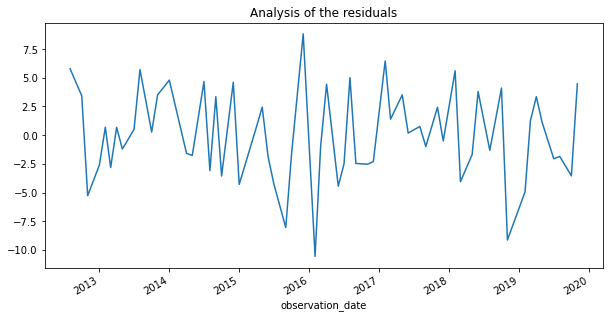

In [152]:
results.plot(figsize=(10,5))
plt.title('Analysis of the residuals')
plt.show()